<a href="https://colab.research.google.com/github/JurijJusel/Image/blob/t11-CNN-model/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [33]:
import time
from time import gmtime
from time import strftime

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
# from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, classification_report

In [2]:
# connect to dataset in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data


In [3]:
augmented_data_path = '/content/drive/MyDrive/Colab Notebooks/Image/data/augmented/train/'
validate_data_path = '/content/drive/MyDrive/Colab Notebooks/Image/data/augmented/validate/'

In [4]:
data = tf.keras.utils.image_dataset_from_directory(augmented_data_path)
validate_data = tf.keras.utils.image_dataset_from_directory(validate_data_path)

Found 3567 files belonging to 2 classes.
Found 603 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

In [64]:
batch[0].shape

(32, 256, 256, 3)

In [65]:
batch[1]

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

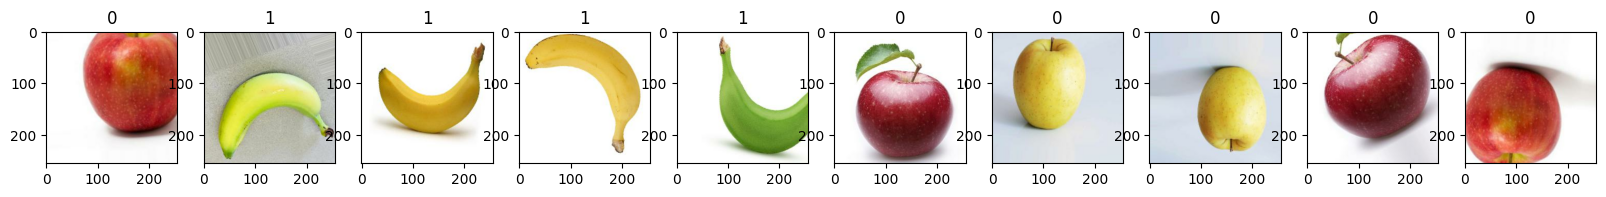

In [9]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Data preprocessing

In [5]:
# Scale Data
data_scale = data.map(lambda x, y:(x/255, y))
# validate_data_scale=validate_data.map(lambda x, y:(x/255, y))


In [ ]:
len(validate_data_scale)

In [7]:
train_size = int(len(data_scale)*0.7)
val_size = int(len(data_scale)*0.2)
test_size = int(len(data_scale)*0.1)+1

In [8]:
train_size

78

In [9]:
val_size

22

In [10]:
test_size

12

In [11]:
train = data_scale.take(train_size)
val = data_scale.skip(train_size).take(val_size)
test = data_scale.skip(train_size+val_size).take(test_size)

In [12]:
len(test)

12

In [118]:
scaled_iterator = data_scale.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].min()

0.0

In [119]:
batch[0].max()

1.0

In [120]:
batch[0].shape

(32, 256, 256, 3)

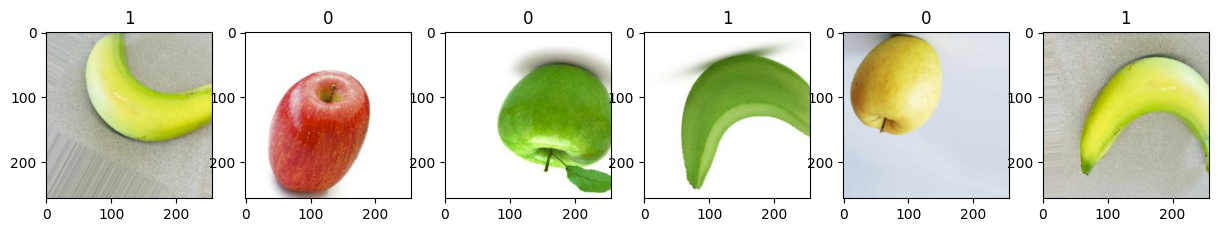

In [121]:
fig, ax = plt.subplots(ncols=6, figsize=(15,15))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
len(data_scale )

112

In [ ]:
len(validate_data)

19

# Build Deep Learning model

In [15]:
model = Sequential()

model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(265, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 265)       152905    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 265)      0

# Train model

In [106]:
def amount_time(func):
    def stopwatch_timer():
        start_time = time.perf_counter()
        trained_model = func()
        # model.save('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_s10_e10_1.h5')
        stop_time = time.perf_counter()
        duration = stop_time - start_time
        durat_str = strftime("%Hh:%Mm:%Ss", gmtime(duration))
        print(durat_str)
        return trained_model
    return stopwatch_timer

In [107]:
@amount_time
def train_model():
    return model.fit(train, steps_per_epoch=10, epochs=10, validation_data=val, validation_steps=10)

In [108]:
trained_model=train_model()

Epoch 1/10
10/10 [==============================] - 75s 7s/step - loss: 1.2232 - accuracy: 0.5344 - val_loss: 0.6297 - val_accuracy: 0.6187
Epoch 2/10
10/10 [==============================] - 65s 7s/step - loss: 0.5028 - accuracy: 0.7656 - val_loss: 0.3199 - val_accuracy: 0.8500
Epoch 3/10
10/10 [==============================] - 68s 7s/step - loss: 0.3181 - accuracy: 0.8562 - val_loss: 0.2235 - val_accuracy: 0.8750
Epoch 4/10
10/10 [==============================] - 67s 7s/step - loss: 0.2083 - accuracy: 0.9031 - val_loss: 0.1233 - val_accuracy: 0.9656
Epoch 5/10
10/10 [==============================] - 67s 7s/step - loss: 0.1717 - accuracy: 0.9438 - val_loss: 0.1284 - val_accuracy: 0.9375
Epoch 6/10
10/10 [==============================] - 67s 7s/step - loss: 0.1926 - accuracy: 0.9219 - val_loss: 0.1037 - val_accuracy: 0.9625
Epoch 7/10
10/10 [==============================] - 70s 7s/step - loss: 0.1454 - accuracy: 0.9469 - val_loss: 0.1289 - val_accuracy: 0.9375
Epoch 8/10
 8/10 [==

10/10 [==============================] - 58s 6s/step - loss: 0.0999 - accuracy: 0.9688 - val_loss: 0.0909 - val_accuracy: 0.9688
00h:09m:24s


In [109]:
trained_model.history

{'loss': [1.223231554031372,
  0.5028170943260193,
  0.3180556893348694,
  0.20831947028636932,
  0.17167608439922333,
  0.19260059297084808,
  0.1453578919172287,
  0.0999165028333664],
 'accuracy': [0.534375011920929,
  0.765625,
  0.856249988079071,
  0.903124988079071,
  0.9437500238418579,
  0.921875,
  0.9468749761581421,
  0.96875],
 'val_loss': [0.6297410130500793,
  0.31994813680648804,
  0.22350673377513885,
  0.12334545701742172,
  0.1284296065568924,
  0.10371311008930206,
  0.1288633942604065,
  0.09086216986179352],
 'val_accuracy': [0.6187499761581421,
  0.8500000238418579,
  0.875,
  0.965624988079071,
  0.9375,
  0.9624999761581421,
  0.9375,
  0.96875]}

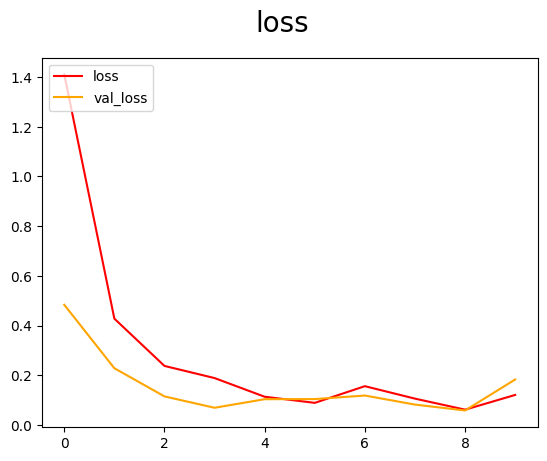

In [52]:
#Plot Performance
fig=plt.figure()
plt.plot(trained_model.history['loss'], color='red', label='loss')
plt.plot(trained_model.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

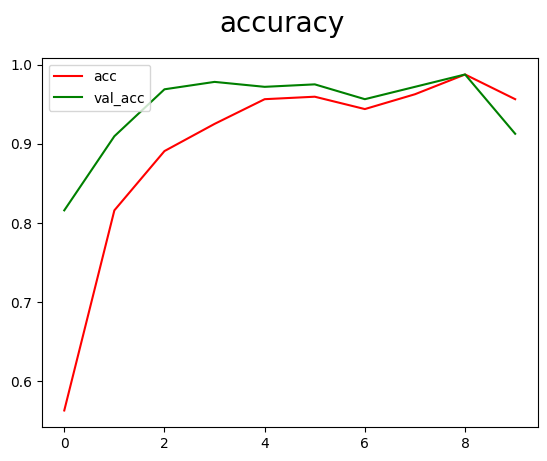

In [53]:
fig=plt.figure()
plt.plot(trained_model.history['accuracy'], color='red', label='acc')
plt.plot(trained_model.history['val_accuracy'], color='green', label='val_acc')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Perfomance

In [38]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_s10_e10.h5')

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    model_predict = new_model.predict(X)
    pre.update_state(y, model_predict)
    re.update_state(y, model_predict)
    acc.update_state(y, model_predict)

1/1 [==============================] - 1s 1s/step


In [41]:
pre.result().numpy()

0.9318182

In [42]:
re.result().numpy()

0.9010989

In [43]:
acc.result().numpy()

0.9182561



# Save model

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_s10_e10.h5')

# Test image

In [112]:
# user_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/apple/Image_47.jpg'  # apple
user_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/banana/Image_95.jpg'  # banana

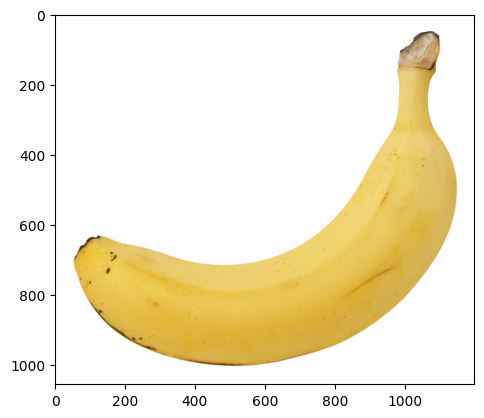

In [113]:
img_read = cv2.imread(user_image)
plt.imshow(cv2.cvtColor(img_read,cv2.COLOR_BGR2RGB))
plt.show()
# img_path

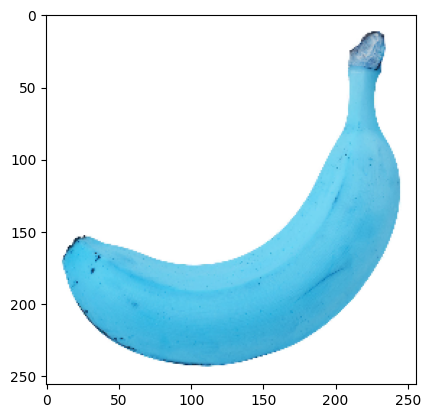

In [114]:
img_resize = cv2.resize(img_read, (256, 256))
plt.imshow(img_resize)
plt.show()

In [ ]:
# np_exp= np.expand_dims(img_resize,0).shape

In [115]:
img_array = np.array(img_resize) / 255.0  # normalize pixel values
img_expanded = np.expand_dims(img_array, axis=0)  # expand dimensions to match input shape


# Predict load model


In [116]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_s10_e10_1.h5')

In [117]:
predictions = new_model.predict(img_expanded, batch_size=10, verbose=0)
predictions

array([[0.925627]], dtype=float32)

# Confusion matrix

In [ ]:
# # confusion matrix
# import seaborn as sns
# # Predict the values from the validation dataset
# Y_pred = model.predict(X_val)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# # Convert validation observations to one hot vectors
# Y_true = np.argmax(Y_val,axis = 1) 
# # compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# # plot the confusion matrix
# f,ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

In [34]:
# predict on validation data
y_pred = new_model.predict(val)
y_pred_classes = np.argmax(y_pred, axis=1)

22/22 [==============================] - 56s 2s/step


In [53]:
y_pred.shape


(704, 1)

In [54]:
y_pred_classes.shape

(704,)

In [36]:
# get true classes
y_true = np.concatenate([y for x, y in val], axis=0)
# y_true_classes = np.argmax(y_pred, axis=1)

# create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm

array([[351,   0],
       [353,   0]])

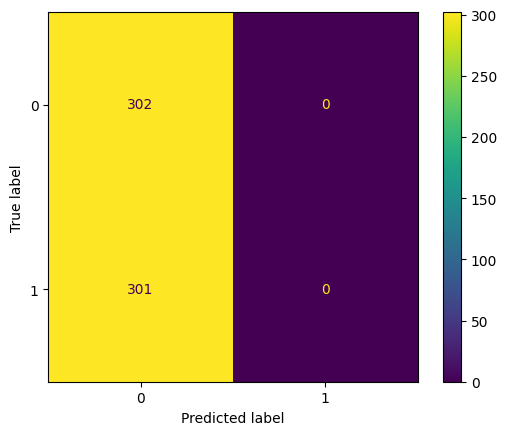

In [63]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()